Loading 2020 census tracts...

=== YEAR 2021 ===
  Found 57 NDBI tiles.
  Detected raster CRS: EPSG:4326
  Reprojecting tracts to raster CRS (once)...
  Processing AL_2021_summer_ndbi_30m.tif for AL (1436 tracts)...


/home/bdevoe/.local/lib/python3.9/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


  Processing AR_2021_summer_ndbi_30m.tif for AR (823 tracts)...
  Processing AZ_2021_summer_ndbi_30m-024.tif for AZ (1765 tracts)...
  Processing CA_2021_summer_ndbi_30m-0000000000-0000000000-026.tif for CA (9109 tracts)...
  Processing CA_2021_summer_ndbi_30m-0000000000-0000032768.tif for CA (9109 tracts)...
  Processing CA_2021_summer_ndbi_30m-0000032768-0000000000.tif for CA (9109 tracts)...
  Processing CA_2021_summer_ndbi_30m-0000032768-0000032768.tif for CA (9109 tracts)...
  Processing CO_2021_summer_ndbi_30m-025.tif for CO (1447 tracts)...
  Processing CT_2021_summer_ndbi_30m.tif for CT (879 tracts)...
  Processing DC_2021_summer_ndbi_30m.tif for DC (206 tracts)...
  Processing DE_2021_summer_ndbi_30m.tif for DE (259 tracts)...
  Processing FL_2021_summer_ndbi_30m.tif for FL (5122 tracts)...
  Processing GA_2021_summer_ndbi_30m.tif for GA (2791 tracts)...
  Processing IA_2021_summer_ndbi_30m.tif for IA (896 tracts)...
  Processing ID_2021_summer_ndbi_30m.tif for ID (456 tracts)

/tmp/ipykernel_83385/876425022.py:245: UserWarning: Geometry column does not contain geometry.
  tracts_for_csv["geometry"] = tracts_for_csv.geometry.to_wkt()


  -> /mnt/sda-21.8/bdevoe/greenspace/processed/tract_ndbi_summer_2021_2025_summary.csv
Plotting and saving mean NDBI map...
  -> /mnt/sda-21.8/bdevoe/greenspace/figures/tract_ndbi_summer_2021_2025_mean_ndbi_map.png


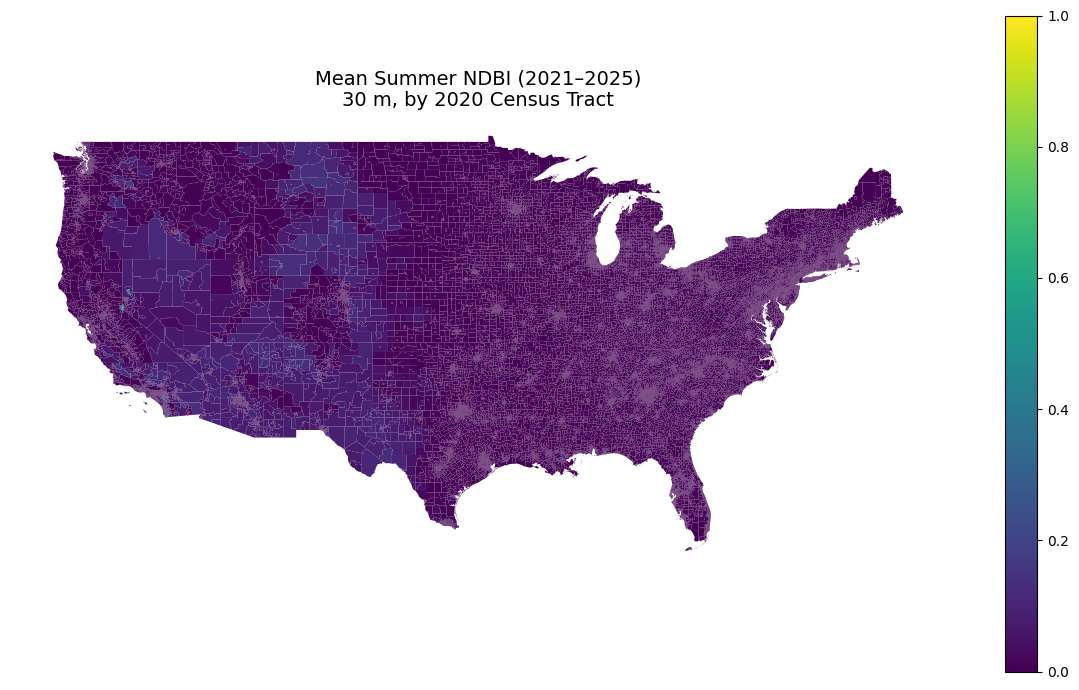

Done.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Paths and basic config
# ---------------------------------------------------------

# Main greenspace directory on the server
REPO_ROOT = Path("/mnt/sda-21.8/bdevoe/greenspace")

# Subdirectories (automatically created if missing)
RESOURCES_DIR = REPO_ROOT / "resources"
RAW_DIR       = REPO_ROOT
NDBI_ROOT     = RAW_DIR / "ndbi"          # <-- where your NDBI GeoTIFFs go
PROCESSED_DIR = REPO_ROOT / "processed"
FIGURES_DIR   = REPO_ROOT / "figures"
OUTPUT_DIR    = REPO_ROOT / "output"

# Example resource files
TRACTS_SHP      = RESOURCES_DIR / "tracts" / "cb_2020_us_tract_500k.shp"
STATE_FIPS_FILE = RESOURCES_DIR / "StateFipsUsps.csv"

# Years to include in the multi-year stats
YEARS = [2021, 2022, 2023, 2024, 2025]
YEAR_START = min(YEARS)
YEAR_END   = max(YEARS)

# ---------------------------------------------------------
# Load tracts + state lookup
# ---------------------------------------------------------
print("Loading 2020 census tracts...")
tracts = gpd.read_file(TRACTS_SHP)
tracts = tracts[["GEOID", "STATEFP", "geometry"]].copy()
tracts = tracts.reset_index(drop=True)

n_tracts = len(tracts)

state_lut = pd.read_csv(STATE_FIPS_FILE, dtype=str)
usps_to_fips = dict(zip(state_lut["USPS"], state_lut["FIPS"]))

# ---------------------------------------------------------
# Initialize accumulators
# ---------------------------------------------------------
# For mean/std/min/max/quantiles (based on per-tile/year mean NDBI)
tracts["ndbi_sum"]    = 0.0
tracts["ndbi_sum_sq"] = 0.0
tracts["ndbi_count"]  = 0
tracts["ndbi_min"]    = np.inf
tracts["ndbi_max"]    = -np.inf

# For pixel-level thresholds across all years/tiles
tracts["ndbi_pix_count"]  = 0
tracts["ndbi_pix_ge_050"] = 0
tracts["ndbi_pix_ge_075"] = 0
tracts["ndbi_pix_ge_090"] = 0

# For median / quantiles of mean NDBI (across years/tiles)
all_vals = [[] for _ in range(n_tracts)]

# Will hold reprojected tracts once raster CRS is known
tracts_proj = None

# ---------------------------------------------------------
# Loop over years and tiles
# ---------------------------------------------------------
for year in YEARS:
    year_dir = NDBI_ROOT / str(year)
    if not year_dir.exists():
        print(f"=== YEAR {year}: directory not found: {year_dir}")
        continue

    tif_paths = sorted(year_dir.glob("*.tif"))
    print(f"\n=== YEAR {year} ===")
    print(f"  Found {len(tif_paths)} NDBI tiles.")

    if not tif_paths:
        continue

    for tif_path in tif_paths:

        # Deduce state from filename prefix
        usps = tif_path.name[:2]
        fips = usps_to_fips.get(usps)

        if fips is None:
            print(f"  Skipping {tif_path.name}: no FIPS for USPS='{usps}'")
            continue

        with rasterio.open(tif_path) as src:

            # Set raster CRS once, reproject tracts once
            if tracts_proj is None:
                print(f"  Detected raster CRS: {src.crs}")
                print("  Reprojecting tracts to raster CRS (once)...")
                tracts_proj = tracts.to_crs(src.crs)

            # Select tracts for this state
            state_mask = tracts_proj["STATEFP"] == fips
            tracts_state = tracts_proj[state_mask]

            if tracts_state.empty:
                print(f"  No tracts found for state {usps}; skipping.")
                continue

            print(f"  Processing {tif_path.name} for {usps} ({len(tracts_state)} tracts)...")

            zs = zonal_stats(
                vectors=tracts_state["geometry"],
                raster=src.read(1),         # NDBI already float32 in [-1, 1]
                affine=src.transform,
                nodata=src.nodata,
                stats=["mean"],
                all_touched=False,
                raster_out=True,            # mini_raster_array for thresholds
            )

        # Accumulate tracts results
        for idx, z in zip(tracts_state.index, zs):
            val = z["mean"]
            if val is None or np.isnan(val):
                continue

            # -----------------------------
            # 1) Summary stats accumulators
            # -----------------------------
            tracts.at[idx, "ndbi_sum"]    += val
            tracts.at[idx, "ndbi_sum_sq"] += val * val
            tracts.at[idx, "ndbi_count"]  += 1

            tracts.at[idx, "ndbi_min"] = min(tracts.at[idx, "ndbi_min"], val)
            tracts.at[idx, "ndbi_max"] = max(tracts.at[idx, "ndbi_max"], val)

            all_vals[idx].append(val)

            # -----------------------------
            # 2) Pixel-level thresholds
            # -----------------------------
            mini = z.get("mini_raster_array", None)
            if mini is None:
                continue

            vals = mini.compressed().astype(float)
            if vals.size == 0:
                continue

            n_pix  = vals.size
            cnt50  = np.count_nonzero(vals >= 0.50)
            cnt75  = np.count_nonzero(vals >= 0.75)
            cnt90  = np.count_nonzero(vals >= 0.90)

            tracts.at[idx, "ndbi_pix_count"]  += n_pix
            tracts.at[idx, "ndbi_pix_ge_050"] += cnt50
            tracts.at[idx, "ndbi_pix_ge_075"] += cnt75
            tracts.at[idx, "ndbi_pix_ge_090"] += cnt90

# ---------------------------------------------------------
# Compute multi-year summary stats per tract
# ---------------------------------------------------------
print("\nComputing multi-year NDBI summary stats per tract...")

valid_mask = tracts["ndbi_count"] > 0
n_valid = int(valid_mask.sum())
print(f"  Tracts with at least one NDBI observation: {n_valid} of {n_tracts}")

# Mean and std
mean_ndbi = np.full(n_tracts, np.nan)
std_ndbi  = np.full(n_tracts, np.nan)

mean_ndbi[valid_mask.values] = (
    tracts.loc[valid_mask, "ndbi_sum"] / tracts.loc[valid_mask, "ndbi_count"]
).to_numpy()

var = (
    tracts.loc[valid_mask, "ndbi_sum_sq"] / tracts.loc[valid_mask, "ndbi_count"]
).to_numpy() - mean_ndbi[valid_mask.values] ** 2

std_ndbi[valid_mask.values] = np.sqrt(np.maximum(var, 0.0))

# Min/max
min_ndbi = tracts["ndbi_min"].to_numpy()
max_ndbi = tracts["ndbi_max"].to_numpy()
min_ndbi[~valid_mask.values] = np.nan
max_ndbi[~valid_mask.values] = np.nan

# Median and quantiles from stored mean values
median_ndbi = np.full(n_tracts, np.nan)
q10_ndbi    = np.full(n_tracts, np.nan)
q25_ndbi    = np.full(n_tracts, np.nan)
q75_ndbi    = np.full(n_tracts, np.nan)
q90_ndbi    = np.full(n_tracts, np.nan)

for i, vals in enumerate(all_vals):
    if not vals:
        continue
    arr = np.array(vals, dtype=float)
    median_ndbi[i] = np.median(arr)
    q10_ndbi[i]    = np.percentile(arr, 10)
    q25_ndbi[i]    = np.percentile(arr, 25)
    q75_ndbi[i]    = np.percentile(arr, 75)
    q90_ndbi[i]    = np.percentile(arr, 90)

# Pixel-level threshold percentages
pix_count = tracts["ndbi_pix_count"].to_numpy(dtype=float)
pct_ndbi_ge_050 = np.full(n_tracts, np.nan)
pct_ndbi_ge_075 = np.full(n_tracts, np.nan)
pct_ndbi_ge_090 = np.full(n_tracts, np.nan)

pix_mask = pix_count > 0
pct_ndbi_ge_050[pix_mask] = (
    100.0 * tracts.loc[pix_mask, "ndbi_pix_ge_050"].to_numpy() / pix_count[pix_mask]
)
pct_ndbi_ge_075[pix_mask] = (
    100.0 * tracts.loc[pix_mask, "ndbi_pix_ge_075"].to_numpy() / pix_count[pix_mask]
)
pct_ndbi_ge_090[pix_mask] = (
    100.0 * tracts.loc[pix_mask, "ndbi_pix_ge_090"].to_numpy() / pix_count[pix_mask]
)

# Attach final stats to tracts GeoDataFrame
tracts["mean_ndbi"]       = mean_ndbi
tracts["std_ndbi"]        = std_ndbi
tracts["min_ndbi"]        = min_ndbi
tracts["max_ndbi"]        = max_ndbi
tracts["median_ndbi"]     = median_ndbi
tracts["q10_ndbi"]        = q10_ndbi
tracts["q25_ndbi"]        = q25_ndbi
tracts["q75_ndbi"]        = q75_ndbi
tracts["q90_ndbi"]        = q90_ndbi
tracts["pct_ndbi_ge_050"] = pct_ndbi_ge_050
tracts["pct_ndbi_ge_075"] = pct_ndbi_ge_075
tracts["pct_ndbi_ge_090"] = pct_ndbi_ge_090

# ---------------------------------------------------------
# Save CSV to data/processed
# ---------------------------------------------------------
print("Saving CSV with NDBI summary stats to data/processed...")

tracts_for_csv = tracts.copy()
tracts_for_csv["geoid"] = tracts_for_csv["GEOID"]
tracts_for_csv["geometry"] = tracts_for_csv.geometry.to_wkt()

csv_cols = [
    "geoid",
    "GEOID",
    "geometry",
    "mean_ndbi",
    "median_ndbi",
    "min_ndbi",
    "max_ndbi",
    "std_ndbi",
    "q10_ndbi",
    "q25_ndbi",
    "q75_ndbi",
    "q90_ndbi",
    "pct_ndbi_ge_050",
    "pct_ndbi_ge_075",
    "pct_ndbi_ge_090",
]

csv_path = PROCESSED_DIR / f"tract_ndbi_summer_{YEAR_START}_{YEAR_END}_summary.csv"
tracts_for_csv[csv_cols].to_csv(csv_path, index=False)
print(f"  -> {csv_path}")

# ---------------------------------------------------------
# Plot and save choropleth map of mean NDBI
# ---------------------------------------------------------
print("Plotting and saving mean NDBI map...")

fig, ax = plt.subplots(figsize=(12, 7))
tracts.plot(
    column="mean_ndbi",
    ax=ax,
    legend=True,
    cmap="viridis",
    linewidth=0,
    vmin=0.0,
    vmax=1.0,
)

ax.set_title(
    f"Mean Summer NDBI ({YEAR_START}–{YEAR_END})\n30 m, by 2020 Census Tract",
    fontsize=14,
)
ax.set_axis_off()

plt.tight_layout()

fig_path = FIGURES_DIR / f"tract_ndbi_summer_{YEAR_START}_{YEAR_END}_mean_ndbi_map.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"  -> {fig_path}")

plt.show()
print("Done.")
